In [1]:
%load_ext autoreload
%autoreload 2
import numpy as np
import scipy as sp
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
from viz import viz
from bokeh.plotting import figure, show, output_notebook, output_file, save
from functions import merge_data
import load_data

from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor

Loading BokehJS ...

In [27]:
df = load_data.load_county_level()
deaths_keys = [k for k in df.keys() if '#Deaths' in k]
cases_keys = [k for k in df.keys() if '#Cases' in k]
deaths = df[deaths_keys].values
cases = df[cases_keys].values
df['deaths'] = [deaths[i] for i in range(deaths.shape[0])]
df['cases'] = [cases[i] for i in range(cases.shape[0])]

# potentially useful info

In [28]:
demographics = ['PopulationEstimate2018', 'Population(Persons)2017',  
                'PopTotalMale2017', 'PopTotalFemale2017', 'FracMale2017',
                'PopulationEstimate65+2017',
                'PopulationDensityperSqMile2010',
                'MedianAge2010', 'MedianAge,Male2010', 'MedianAge,Female2010']

# hospital vars
hospitals_hrsa = ['#FTEHospitalTotal2017', "TotalM.D.'s,TotNon-FedandFed2017", '#HospParticipatinginNetwork2017']
hospitals_misc = ["#Hospitals", "#ICU_beds"]
hospitals = hospitals_hrsa + hospitals_misc

# comorbidity (simultaneous presence of multiple conditions) vars
comorbidity_hrsa = [ '#EligibleforMedicare2018',  'MedicareEnrollment,AgedTot2017', '3-YrDiabetes2015-17']
comorbidity_misc = ["DiabetesPercentage", "HeartDiseaseMortality", "StrokeMortality", "Smokers_Percentage"]
comorbidity = comorbidity_hrsa + comorbidity_misc

# political leanings (ratio of democrat : republican votes in 2016 presidential election)
political = ['dem_to_rep_ratio']

important_vars = demographics + comorbidity + hospitals + political

# look at one county

In [29]:
row = df.iloc[0]

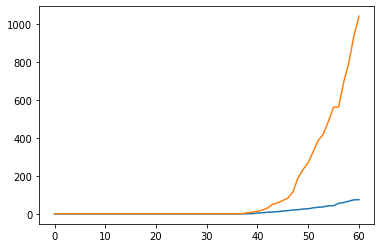

In [30]:
plt.plot(row['deaths'], label='deaths')
plt.plot(row['cases'], label='cases')
plt.legend()
plt.show()

In [31]:
print(row[important_vars])

PopulationEstimate2018              2.23316e+06
Population(Persons)2017             2.18865e+06
PopTotalMale2017                    1.09678e+06
PopTotalFemale2017                  1.09186e+06
FracMale2017                           0.501124
PopulationEstimate65+2017                283909
PopulationDensityperSqMile2010            912.9
MedianAge2010                              37.1
MedianAge,Male2010                         36.3
MedianAge,Female2010                       37.9
#EligibleforMedicare2018                 333432
MedicareEnrollment,AgedTot2017           271948
3-YrDiabetes2015-17                         386
DiabetesPercentage                          7.1
HeartDiseaseMortality                     118.9
StrokeMortality                            29.6
Smokers_Percentage                      8.81505
#FTEHospitalTotal2017                     41960
TotalM.D.'s,TotNon-FedandFed2017          12918
#HospParticipatinginNetwork2017              14
#Hospitals                              